In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
mnase = pd.read_hdf('data/mnase_seq_merged_sampled.h5.z')

In [4]:
orfs = pd.read_csv('data/orfs_cd_paper_dataset.csv').set_index('orf_name')

In [33]:
mnase_0 = mnase[mnase.time == 0.0]
mnase_120 = mnase[mnase.time == 120.0]

In [23]:
gene = orfs.loc['YPR167C']

In [34]:
from src.vit_img_gen import ViTImgGen

# Partitions lengths of fragments into equal sized (length-wise) patches
# Small fragments: 30-79
# Intermediate fragments: 80-129
# Nucleosomal fragments: 130-200
len_cuts = [30, 80, 130, 201]
window = 1024

# Window = 1024
# Resize = 64   (16 downscale)
# Patch size = 4
# 64 / 4 = 16 column patches
# 1024 / 16 = 64 bps per patch
# 12x64 shaped images
patch_size = 8
sublength_resize_height = patch_size # times 3 vertical patches of height
img_width = 128

vit_gen = ViTImgGen(mnase_120, window, sublength_resize_height, len_cuts,
                    img_width, patch_size)


In [35]:
patch_size

8

In [41]:
img, scaled_img, smoothed, img_slices = vit_gen.get_mnase_img(gene)

In [42]:
scaled_img.shape

(24, 128)

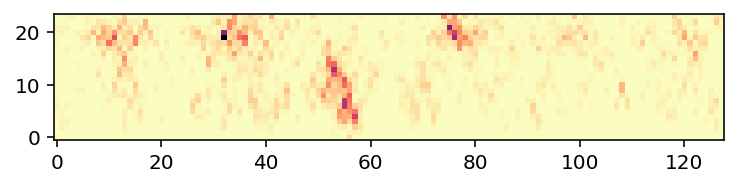

In [43]:
plt.imshow(scaled_img, cmap='magma_r', origin='lower')

In [ ]:
vit_gen.plot_resized_img()

In [11]:
from src.vit_data import read_pickle
desc, imgs = read_pickle('data/vit/cd/vit_imgs_24x128_DM498_MNase_rep1_0_min.pkl')

In [12]:
imgs.shape

(4427, 1, 24, 128)

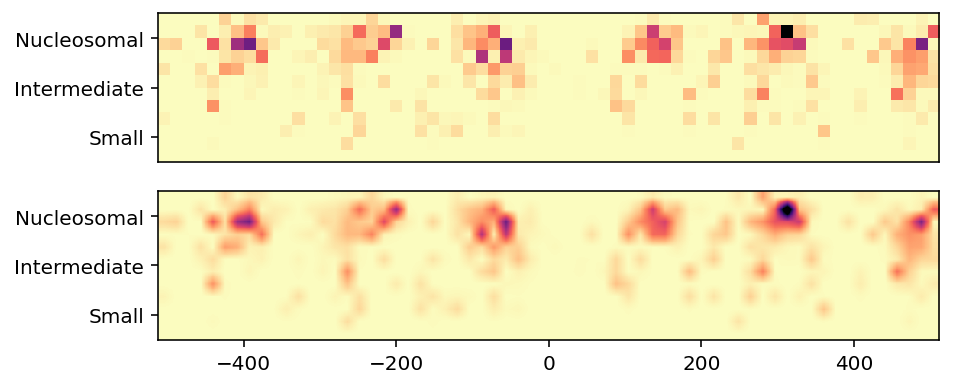

In [791]:
from src.vit_img_gen import plot_scaled

idx = 10
plt.figure(figsize=(7, 3))
plt.subplot(2, 1, 1)
plot_scaled(imgs[idx], vit_gen.window)
plt.xticks([])

plt.subplot(2, 1, 2)
rescaled_t = cv2.resize(imgs[idx], (vit_gen.window, len_cuts[-1]-len_cuts[0]))
plot_scaled(rescaled_t, vit_gen.window)


In [842]:
from src.read_bam import read_rna_seq
from src.timer import Timer

timer = Timer()

rna_0_1 = read_rna_seq('../data/bam/cd/rna/DM538_RNA_rep1_0_min.bam', 0.0)
rna_0_2 = read_rna_seq('../data/bam/cd/rna/DM1450_RNA_rep2_0_min.bam', 0.0, timer)


In [853]:
from src.transcription import calculate_read_counts

orf_reads_1 = calculate_read_counts(orfs, rna_0_1)
orf_reads_2 = calculate_read_counts(orfs, rna_0_2)


In [858]:
orf_read_counts = orf_reads_1[[]]
orf_read_counts[0.0] = orf_reads_1

In [870]:
orf_reads_1

,count
orf_name,
YAL063C,27
YAL062W,237
YAL061W,164
YAL060W,1072
YAL059W,2591
...,...
YPR191W,8760
YPR196W,480
YPR198W,1414


In [866]:
rna_bam_files = [(0.0, '/Users/trung/Research/data/bam/cd/rna/DM538_RNA_rep1_0_min.bam'),
                 (7.5, '/Users/trung/Research/data/bam/cd/rna/DM539_RNA_rep1_7.5_min.bam'),
                 (15.0, '/Users/trung/Research/data/bam/cd/rna/DM540_RNA_rep1_15_min.bam'),
                 (30.0, '/Users/trung/Research/data/bam/cd/rna/DM541_RNA_rep1_30_min.bam'),
                 (60.0, '/Users/trung/Research/data/bam/cd/rna/DM542_RNA_rep1_60_min.bam'),
                 (120.0, '/Users/trung/Research/data/bam/cd/rna/DM543_RNA_rep1_120_min.bam')]


[(0.0, '/Users/trung/Research/data/bam/cd/rna/DM538_RNA_rep1_0_min.bam'),
 (7.5, '/Users/trung/Research/data/bam/cd/rna/DM539_RNA_rep1_7.5_min.bam'),
 (15.0, '/Users/trung/Research/data/bam/cd/rna/DM540_RNA_rep1_15_min.bam'),
 (30.0, '/Users/trung/Research/data/bam/cd/rna/DM541_RNA_rep1_30_min.bam'),
 (60.0, '/Users/trung/Research/data/bam/cd/rna/DM542_RNA_rep1_60_min.bam'),
 (120.0, '/Users/trung/Research/data/bam/cd/rna/DM543_RNA_rep1_120_min.bam')]

In [879]:
from src.timer import Timer

timer = Timer()
read_counts = orfs[[]].copy()
for time, bam_path in rna_bam_files:
    timer.print_label(f"{time}, reading BAM", end='...')
    rna_seq = read_rna_seq(bam_path, time)
    timer.print_label("Calculating read counts", end='...')
    cur_read_counts = calculate_read_counts(orfs, rna_seq)['count']
    read_counts.loc[:, time] = cur_read_counts
    print('Done.')


0.0, reading BAM... - 00:00:00.00Calculating read counts... - 00:01:24.06Done.
7.5, reading BAM... - 00:01:42.55Calculating read counts... - 00:02:51.80Done.
15.0, reading BAM... - 00:03:07.95Calculating read counts... - 00:04:17.76Done.
30.0, reading BAM... - 00:04:34.56

[W::hts_idx_load3] The index file is older than the data file: /Users/trung/Research/data/bam/cd/rna/DM541_RNA_rep1_30_min.bam.bai


Calculating read counts... - 00:05:39.24Done.
60.0, reading BAM... - 00:05:54.85Calculating read counts... - 00:06:57.54Done.
120.0, reading BAM... - 00:07:12.72Calculating read counts... - 00:08:12.23Done.


In [882]:
read_counts_rep1 = read_counts

In [883]:
read_counts_rep1.head(2)

,0.0,7.5,15.0,30.0,60.0,120.0
orf_name,,,,,,
YAL063C,27,32,39,57,93,82
YAL062W,237,157,347,1182,2736,3179


In [881]:
rna_bam_files = [(0.0, '/Users/trung/Research/data/bam/cd/rna/DM1450_RNA_rep2_0_min.bam'),
                 (7.5, '/Users/trung/Research/data/bam/cd/rna/DM1451_RNA_rep2_7.5_min.bam'),
                 (15.0, '/Users/trung/Research/data/bam/cd/rna/DM1452_RNA_rep2_15_min.bam'),
                 (30.0, '/Users/trung/Research/data/bam/cd/rna/DM1453_RNA_rep2_30_min.bam'),
                 (60.0, '/Users/trung/Research/data/bam/cd/rna/DM1454_RNA_rep2_60_min.bam'),
                 (120.0, '/Users/trung/Research/data/bam/cd/rna/DM1455_RNA_rep2_120_min.bam')]


In [884]:
from src.timer import Timer

timer = Timer()
read_counts = orfs[[]].copy()
for time, bam_path in rna_bam_files:
    timer.print_label(f"{time}, reading BAM", end='...')
    rna_seq = read_rna_seq(bam_path, time)
    timer.print_label("Calculating read counts", end='...')
    cur_read_counts = calculate_read_counts(orfs, rna_seq)['count']
    read_counts.loc[:, time] = cur_read_counts
    print('Done.')


0.0, reading BAM - 00:00:00.00...Calculating read counts - 00:00:51.76...Done.
7.5, reading BAM - 00:01:04.69...Calculating read counts - 00:01:50.18...Done.
15.0, reading BAM - 00:02:02.08...

[W::hts_idx_load3] The index file is older than the data file: /Users/trung/Research/data/bam/cd/rna/DM1452_RNA_rep2_15_min.bam.bai


Calculating read counts - 00:02:42.31...Done.
30.0, reading BAM - 00:02:53.06...

[W::hts_idx_load3] The index file is older than the data file: /Users/trung/Research/data/bam/cd/rna/DM1453_RNA_rep2_30_min.bam.bai


Calculating read counts - 00:03:35.39...Done.
60.0, reading BAM - 00:03:47.10...

[W::hts_idx_load3] The index file is older than the data file: /Users/trung/Research/data/bam/cd/rna/DM1454_RNA_rep2_60_min.bam.bai


Calculating read counts - 00:04:25.15...Done.
120.0, reading BAM - 00:04:35.63...Calculating read counts - 00:05:05.48...Done.


In [915]:
combined_read_counts = pd.concat([read_counts_rep1, read_counts_rep2]).groupby('orf_name').sum()

In [917]:
from src.transcription import convert_to_TPM

times = [0.0, 7.5, 15, 30, 60, 120]
TPMs = orfs[[]].copy()
for time in times:
    TPMs.loc[:, time] = convert_to_TPM(combined_read_counts[time], orf['length'])
TPMs.to_csv('data/vit/cd_rna_seq_TPM.csv')
{{}}